<a href="https://colab.research.google.com/github/dschlesinger/mnist-featurization-workshop/blob/main/mnist_featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello!

Today we will be tackling the MNIST classification problem with no Deep Learning.

Make a copy an follow along!

In [ ]:
from typing import List, Callable, Tuple
import math

import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Load MNIST

In [ ]:
# Loading as full tensor for convience
def load_mnist(batch_size=60000):
    transform = v2.Compose([
        v2.ToImage(),
        # To between 0 and 1
        v2.ToDtype(torch.float32, scale=True)
    ])

    mnist_train = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    # Load entire dataset in one batch
    loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

    X, y = next(iter(loader))

    # Reshape X to get rid of channels
    X.squeeze_(1)

    # One-hot encode labels into 10 classes
    Y = F.one_hot(y, num_classes=10).float()

    return X, Y

X, Y = load_mnist()

In [ ]:
print("X shape:", X.shape)
print("X min & max:", X.min().item(), '&', X.max().item())
print("Y shape:", Y.shape)

X shape: torch.Size([60000, 28, 28])
X min & max: 0.0 & 1.0
Y shape: torch.Size([60000, 10])


### Featurization

One way to think about deep learning is that part of the model learns *embeddings* while the other part predicts the embeddings to a classification. In this case we will be making our own embeddings using logic. This allows us to use smaller models for predicting like decsission trees, linear models, and knns.

Lets make some features

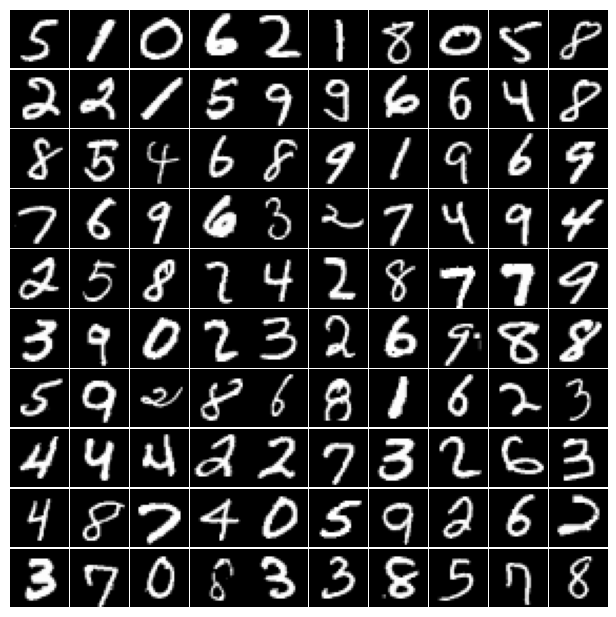

In [ ]:
# Lets look at these images
fig, axs = plt.subplots(10, 10, figsize=(6, 6))

axs = axs.flatten()

# Styling done by chat
for ax, img in zip(axs, X):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(pad=0.1)
plt.show()


Any Ideas for features?
Example maybe roundness

In [ ]:
# Lets make some features
def apply_feature(featurize: Callable, imgs: torch.Tensor) -> torch.Tensor:

  features = []

  for img in imgs:

    features.append(featurize(img))

  return torch.tensor(features)

# We will go over these and uncomment them as we go!
def bounds(img: torch.Tensor) -> Tuple[float]:

  bright_squares = torch.argwhere(img > 0.75)

  minx = torch.min(bright_squares[:, 0])
  maxx = torch.max(bright_squares[:, 0])
  miny = torch.min(bright_squares[:, 1])
  maxy = torch.max(bright_squares[:, 1])

  return (minx, maxx, miny, maxy)

# def circularity(img: torch.Tensor) -> Tuple[float]:
#   """Calculate roundness of our number

#   The Formula is (4 * pi * $area) / ($perimeter) ^ 2
#   $area will be the number of bright squares
#   #perimeter will be the number of square next to a not light one
#   """

#   bright_squares = torch.argwhere(img > 0.75)

#   area = bright_squares.shape[0]

#   # If sum of up down left right is less then 3 then we can assume its a perimeter
#   kernel = torch.tensor([
#       [0, 1, 0],
#       [1, 0, 1],
#       [0, 1, 0],
#     ], dtype=torch.float32
#   ).reshape((1, 1, 3, 3))

#   p = F.conv2d(img.reshape(1, 1, 28, 28), kernel, padding=1)

#   p = p.reshape((28, 28))

#   perimeter = torch.argwhere((p < 3) & (img > 0.75)).shape[0]

#   if perimeter < 1:
#     print('perimeter algo failed :(')
#     return (1.0, )

#   circ = (4 * math.pi * area) / (perimeter ** 2)

#   return (circ, )

# def laterality(img: torch.Tensor) -> Tuple[float]:

#   top_left = img[:14, :14].sum()
#   top_right = img[14:, :14].sum()
#   bottom_left = img[:14, 14:].sum()
#   bottom_right = img[14:, 14:].sum()

#   total = top_left + top_right + \
#           bottom_left + bottom_right

#   return (
#       top_left / total,
#       top_right / total,
#       bottom_left / total,
#       bottom_right / total,
#   )

# def center_brightness(img: torch.Tensor) -> Tuple[float]:

#   center = img[7:21, 7:21]

#   return (center.sum() / img.sum(),)

# def deviation_from_center_line(img: torch.Tensor) -> Tuple[float]:
#   """The deviation of all bright points from the center of the number"""

#   x_std = torch.argwhere(img > 0.75).float().std(dim=0)

#   return (*x_std.flatten().tolist(), )

# def end_to_end_direction(img: torch.Tensor) -> Tuple[float]:
#   """Distance from the farthest left point to the farthest right point"""

#   bright_squares = torch.argwhere(img > 0.75)

#   most_left = bright_squares[:, 0].argmin()
#   most_right = bright_squares[:, 0].argmax()

#   return (
#       *(most_right - most_left).flatten().tolist(),
#   )

featurizers: List[Callable[[torch.tensor], Tuple[float]]] = [
  bounds,
  # circularity,
  # laterality,
  # center_brightness,
  # deviation_from_center_line,
  # end_to_end_direction,
]

In [ ]:
features = []

for featurizer in featurizers:
  print(f'{featurizer.__name__}...')
  clear_output(wait=True)
  features.append(
      apply_feature(featurizer, X)
  )

# Join tensors
features = torch.hstack(features)

# to 0 to 1
features = ((features - torch.min(features, dim=0).values) / torch.max(features, dim=0).values)

features.shape

torch.Size([60000, 4])

### KNN

Lets try a KNN on our features

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

features_np = features.numpy()
classes = Y.argmax(dim=1).numpy()

ts = training_samples = 55_000

X_train = features_np[:ts]
X_test = features_np[ts:]
Y_train = classes[:ts]
Y_test = classes[ts:]

knns = []
up_to_n: int = 100

for n in range(1, up_to_n):

  k = KNeighborsClassifier(n_neighbors=n)

  k.fit(X_train, Y_train)

  print(f'{n}/{up_to_n - 1}')
  clear_output(wait=True)

  knns.append(k)

99/99


In [ ]:
accuracy = []

for i, k in enumerate(knns):

  print(f'{i + 1}/{len(knns)}')
  clear_output(wait=True)

  p = k.predict(X_test)

  acc = np.sum(p == Y_test) / X_test.shape[0]

  accuracy.append(acc)

99/99


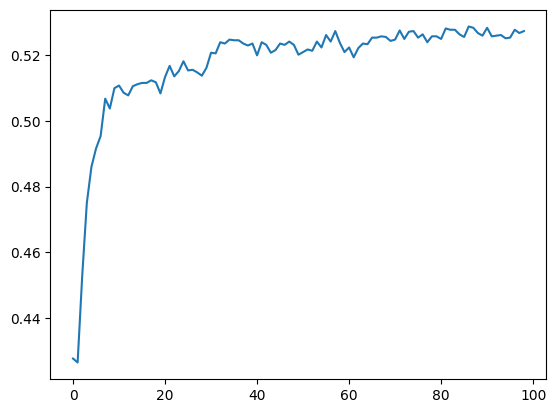

In [ ]:
plt.plot(accuracy)

In [ ]:
confusion_matrix = np.zeros((10, 10))
wrong = []

k = 25

p = knns[k].predict(X_test)

for i, pi, yi in zip(range(len(p)), p, Y_test):

  confusion_matrix[pi, yi] += 1

  if pi != yi:
    wrong.append(i)

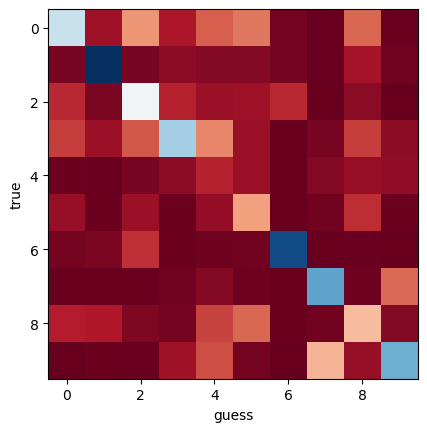

In [ ]:
plt.imshow(confusion_matrix, cmap='RdBu')
plt.xlabel('guess')
plt.ylabel('true')
plt.show()

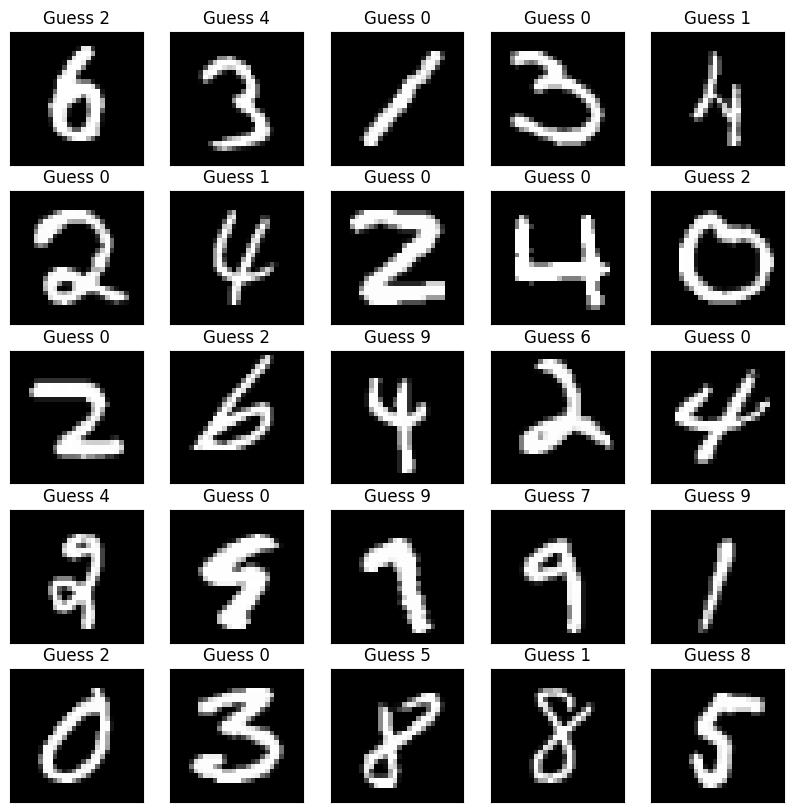

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

axs = axs.flatten()

for w, ax in zip(wrong, axs):

  ax.imshow(X[ts + w], cmap='grey')
  ax.set_title(f'Guess {p[w]}')

  # Remove x-axis ticks
  ax.set_xticks([])
  # Remove y-axis ticks
  ax.set_yticks([])

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

tree.fit(X_train, Y_train)
forest.fit(X_train, Y_train)
pass

In [ ]:
p = tree.predict(X_test)

print('Decison Tree Acc', (Y_test == p).sum() / Y_test.shape[0])

p = forest.predict(X_test)

print('Random Forest Acc', (Y_test == p).sum() / Y_test.shape[0])

Decison Tree Acc 0.5282
Random Forest Acc 0.5286


### Visualize

Lets visualize the feature space with pca!

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pc_train = pca.fit(X_train)

pc_test = pca.transform(X_test)

mcm = mnist_color_map = {
    0: '#1f77b4',  # Muted Blue
    1: '#ff7f0e',  # Safety Orange
    2: '#2ca02c',  # Cooked Asparagus Green
    3: '#d62728',  # Brick Red
    4: '#9467bd',  # Muted Purple
    5: '#8c564b',  # Chestnut Brown
    6: '#e377c2',  # Raspberry Pink
    7: '#7f7f7f',  # Middle Gray
    8: '#bcbd22',  # Curry Yellow-Green
    9: '#17becf'   # Blue-Cyan
}

colors = [mcm[l] for l in Y_test]

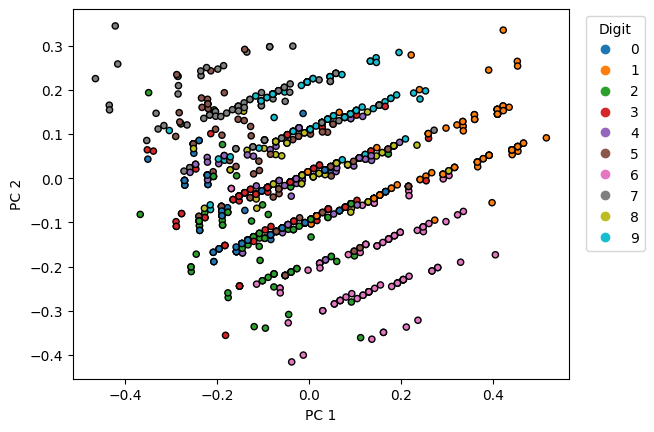

In [ ]:
scatter = plt.scatter(
    *pc_test[:1000].T,
    c=Y_test[:1000],
    cmap='tab10',
    edgecolor='k',
    s=20
)

# Add a legend
plt.legend(
    handles=scatter.legend_elements(num=10)[0],
    labels=list(range(10)),
    title="Digit",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()